In [18]:
import numpy as np
import matplotlib.pyplot as plt

import masks

# On variance

In this notebook we show that:

* the true source significance is much MUCH higher than the cross-correlation significance.
* the cross-correlation variance is the variance you'd expect if all photons came by background.

Let's simulate a photon list and its detector image: 

In [19]:
from masks import ura, pad

mask_size = (61, 59)
mask, decoder = ura(*mask_size)
padded_mask = pad(mask)

In [20]:
from masks import simulate

fsources = [2000, 1000, 500]
brate = 1

photon_list, info = simulate.photon_list(
    fsources = [2000, 1000, 500],
    brate = brate,
    shape = mask_size
)
dsources = info["source_directions"]

In [21]:
skymap_before_mask = simulate.skymap(photon_list, mask_size)
skymap_after_mask = simulate.skymap_transmitted(photon_list, mask)

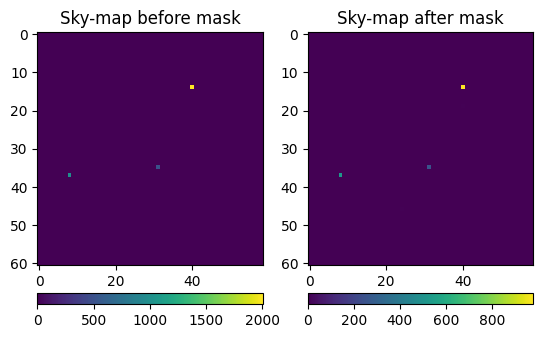

In [22]:
from masks.plot import plotmaps

fig, axs = plotmaps(
    [(skymap_before_mask, "Sky-map before mask"),
     (skymap_after_mask, "Sky-map after mask")])
plt.show()

In [23]:
detector = simulate.transport(photon_list, mask)

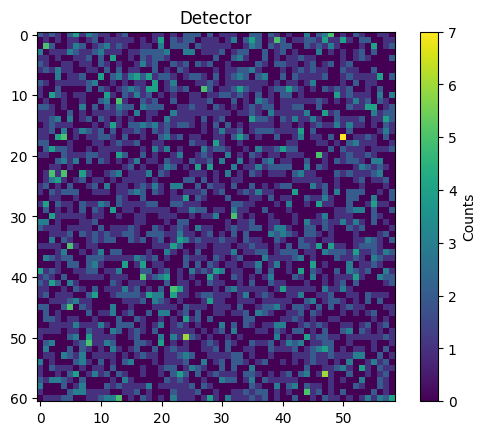

In [24]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

The cross-correlation reconstructed sky image is:

In [25]:
from masks import reconstruct

skymap_cc = reconstruct.cross_correlation(detector, decoder)

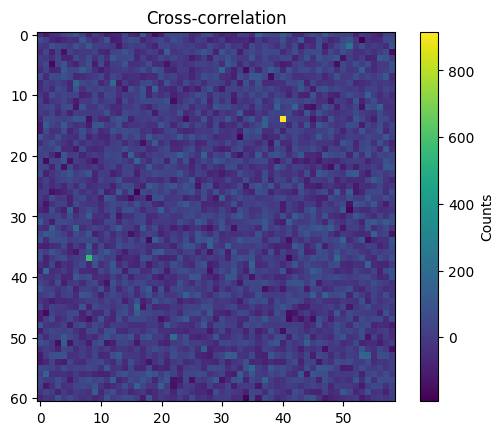

In [26]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_cc)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Cross-correlation")
plt.show()

The SNR in literature is computed as the ratio between the crosscorrelation-reconstructed sky image and its variance.

In [27]:
from masks import stats

variance_cc = stats.variance(detector, decoder)
snr_cc = skymap_cc / np.sqrt(variance_cc)

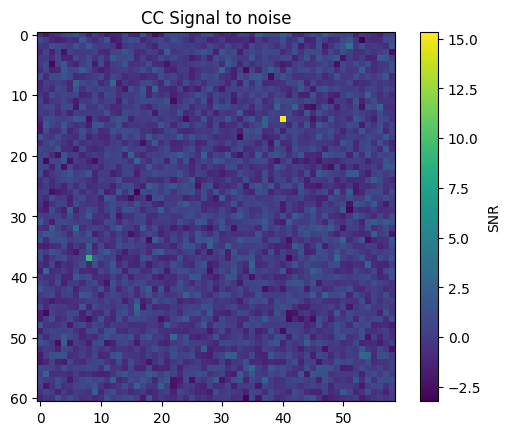

In [28]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(snr_cc)
fig.colorbar(c0, ax=ax, label="SNR")
ax.set_title("CC Signal to noise")
plt.show()

Note that the cross correlation significance is much MUCH different from the actual source significance: 

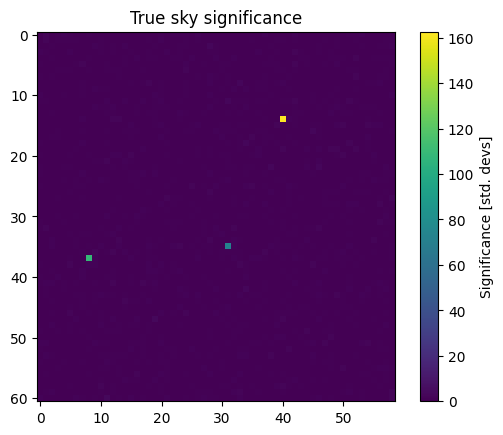

In [38]:
fig, ax = plt.subplots(1, 1)
sign = np.nan_to_num(stats.significance(skymap_before_mask, 1))
c0 = ax.imshow(sign)
fig.colorbar(c0, ax=ax, label="Significance [std. devs]")
ax.set_title("True sky significance")
plt.show()

# Cross-correlation variance

But what do they mean for variance actually?

We run two simulations of 1000 photons list. All simualtion are generated with the same number of photons, but for the first simulation set all photons come from background and a source, while for the second simulation set all photons come from the background.

In [39]:
def simulate_variances(fsources, brate, niter=1000):
    vars = []
    for _ in range(niter):
        photon_list, info = simulate.photon_list(
            fsources = fsources,
            brate = brate, 
            shape = mask_size
        )
        detector = simulate.transport(photon_list, mask)
        skymap_cc = reconstruct.cross_correlation(detector, decoder)
        vars.append(skymap_cc.var())
    return vars

In [57]:
from masks import open_fraction

fsources, brate = [3000], 1
vars_wsource = simulate_variances(fsources, brate)
fsources, brate = [0], 1 + 3000 / np.prod(mask_size)
vars_background = simulate_variances(fsources, brate)

In [60]:
# note, this is the same you'll get with stats.variance!
expected_variance = (np.sum(fsources) + brate * np.prod(mask_size)) * open_fraction(mask)

3300.4167824395668


We can see that the expected variance matches the variance of the simulation only for the set with no source.

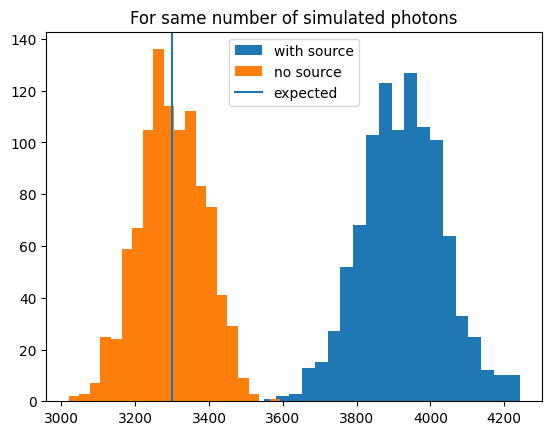

In [61]:
plt.hist(vars_wsource, bins=20, label="with source")
plt.hist(vars_background, bins= 20, label="no source")
plt.axvline(expected_variance, label="expected")
plt.title("For same number of simulated photons")
plt.legend()
plt.show()